<a href="https://colab.research.google.com/github/vircsinger625/Onlab_2020_2/blob/main/%C3%96nlab_3Kutya_StanfordDogsDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Önálló laboratórium beszámoló: Deep learning alapú képfeldolgozás**
### Tábori Virág
### Konzulens: Dr. Szegletes Luca
2020/2021/1


**Feladat ismertetése - Célok**

* Fényképek osztályozása
* Pytorch nyelv megismerése
* Saját konvolúciós háló paraméterezése
* Más architektúrák megismerése
* Eredményeim összegzése


**Képek osztályozása - adatbázis**

* Stanford Dogs Dataset 120 kutyafaj
* 3 kutyával dolgoztam
  * Előnye
    * gyorsaság
  * Hátránya
    * Túl specifikus, nem robosztus
* Fajták szerint külön mappában
* Képek augmentációja, adatbázis dúsítása
  * Szürke árnyalatos
  * Elforgatott (függőleges tükrözés)
* 128x128-as képek



**Lehetséges fejlesztések**

* Más súlyokkal, hiperparaméterek kísérletezés
* Mások eredményeinek mélyebb megismerése
* Túltanulás kezelése

In [ ]:
#Ez egy úgynevezett "magic function", ez teszi lehetővé,
#hogy a megjelenítés megfelelő legyen a nootebookban 
%matplotlib inline

In [ ]:
# torch és a torchvision telepítése linux parancsokkal 
!pip install torch
!pip install torchvision

In [ ]:
## A szükséges importálások elvégzése

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import itertools
import time

import os, sys
import cv2
from PIL import Image

from torch.autograd import Variable

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# A képek megjelenítéséhez szükséges függyvény

def imshow(img):                                 
   #:param img: (PyTorch Tensor)
    img = img / 2 + 0.5                         
   # unnormalize
    npimg = img.numpy()                           
   # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    
   # Color channel first -> color channel last
    plt.show()

In [ ]:
#Új mappa létrehozása az adatok lementéséhez

%cd /home 
!ls
!mkdir -p StanfordDogsDataset
%cd /home/StanfordDogsDataset

In [ ]:
## Az adatbázis letöltése linux serverre a wget linux command segítségével,
# ha még nem létezik az adott file
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/README.txt -P /home/StanfordDogsDataset/

In [ ]:
## A tar fájlok kibontása ezekben találhatóak a képek

!tar -xvf images.tar 
!tar -xvf annotation.tar 
!tar -xvf lists.tar

!ls

In [ ]:
batch_size= 100 #Egyszerre beadott minták száma

Képek beolvasása

In [ ]:
## Az összes kép betöltése 
transform = transforms.Compose(                                        
    # A képek transzformálása
    [transforms.ToTensor(),
     # Normalizálás 0.5-0.5                                         
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),   
     # A képek átméretezése a könnyebb kezelhetesőg érdekében
     transforms.Resize((128, 128))                                      
     ]) 

imgs_dir = '/home/StanfordDogsDataset/Images'   #Az adatbázisom fő mappája
# A képek a osztályuk szerinti mappákban elkülönítve találhatóak
imagenet_data = torchvision.datasets.ImageFolder(imgs_dir, transform=transform) 
total_images_num = len(imagenet_data)           #Az összes kép száma
print(total_images_num)

In [ ]:
## A tanító, teszetelő és validációs adathalmazok szerinti adatbetöltés
# A random_split segítségével választom szét az adatbázisom 3 részre: 
# tanító, tesztelő és validációs
# generátor értékenek beállításval, a manual_seed(42)
# segítségével mindig ugyanazt a szétbontást fogom kapni

train_data, test_data, val_data = torch.utils.data.random_split(
    imagenet_data, [16464, 2058, 2058], 
    generator=torch.Generator().manual_seed(42))

#Az egyes adatok betöltése a megfelelő adatbázisba
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True) 

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)


val_gen = torch.utils.data.DataLoader(dataset = val_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [ ]:
# Az adatok megjelenítése

all_data = len(train_data)+len(test_data)+len(val_data)
total_images_num = len(imagenet_data)
num_classes = len(os.listdir(imgs_dir))

print(all_data == total_images_num)

print('Classes: %d' % (num_classes))
print("Images number: %d" % (total_images_num))

print('Train Data: \t %.3f%%' %torch.true_divide(100*len(train_data),all_data),
      '\t Number of images: ', len(train_data))
print('Test  Data: \t %.3f%%' %torch.true_divide(100*len(test_data),all_data), 
      '\t Number of images:  ', len(test_data))
print('Valid Data: \t %.3f%%' %torch.true_divide(100*len(val_data),all_data), 
      '\t Number of images:  ', len(val_data))

In [ ]:
# Ez a függvény az egyes képekhez hozzárendeli 
# a megfelelő osztály nevet és indexet

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_to_idx = find_classes(imgs_dir)

In [ ]:
## Az összes kutyafajta kilistázása (osztályok)
for i in range(0, num_classes): 
  print("{}-{}".format(i, classes[i][10:]))

Adatok az adatbázisról és képek kirajzolása 

Train random images


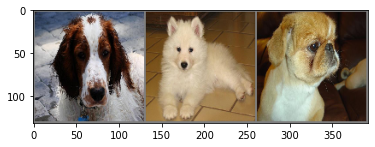

           67           106             3
Welsh_springer_spaniel       Samoyed      Pekinese

Test random images


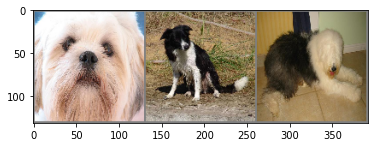

           53            81            78
        Lhasa Border_collie Old_English_sheepdog

Val random images


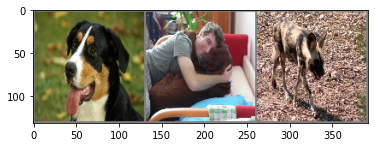

           89            62           119
  Appenzeller  Irish_setter African_hunting_dog


In [ ]:
#Random fényképek megjelnítése az osztály névvel és index-el

num_img = 3 #megjelenítendő képek száma

#Tanító képekből pár random megjelenítés
dataiter = iter(train_gen)
images, labels = dataiter.next()
print("Train random images")
# show images
imshow(torchvision.utils.make_grid(images[0:num_img,:,:,:],  nrow = num_img))
# print labels
print(' '.join('{:>13}'.format(labels[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes[labels[j]][10:]) for j in range(num_img)))

#Teszt képekből pár random megjelenítés
print("\nTest random images")
dataiter = iter(test_gen)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:num_img,:,:,:],  nrow = num_img))
print(' '.join('{:>13}'.format(labels[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes[labels[j]][10:]) for j in range(num_img)))

#Validációs képekből pár random megjelenítés
print("\nVal random images")
dataiter = iter(val_gen)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:num_img,:,:,:],  nrow = num_img))
print(' '.join('{:>13}'.format(labels[j]) for j in range(num_img)))
print(' '.join('{:>13}'.format(classes[labels[j]][10:]) for j in range(num_img)))

**Tanítás 3 kutyával**



Adatok beolvasása

In [ ]:
## 3 fajta kutya képeinek betöltése
# Egy új mappába átmásolom a számomra fontos mappákat. 
%cd /home/StanfordDogsDataset
!mkdir -p dog3_Images
%cd /home/StanfordDogsDataset/dog3_Images

imgs3_dir = '/home/StanfordDogsDataset/dog3_Images'

%cp -R /home/StanfordDogsDataset/Images/n02085936-Maltese_dog /home/StanfordDogsDataset/dog3_Images
%cp -R /home/StanfordDogsDataset/Images/n02087394-Rhodesian_ridgeback /home/StanfordDogsDataset/dog3_Images
%cp -R /home/StanfordDogsDataset/Images/n02105056-groenendael /home/StanfordDogsDataset/dog3_Images

%ls 

In [ ]:
var = 3           # A képeket többször is beteszem az adatbázisba, különböző színekben, elforgatásokban
batch_size= 100

In [ ]:
%rm -f /home/StanfordDogsDataset/dog3_Images/best_model.pth

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((128, 128))    
     ]) 

transformFlip = transforms.Compose(
    [transforms.ToTensor(),     
     transforms.RandomHorizontalFlip(p=1),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((128, 128))    
     ]) 

transformGray = transforms.Compose(
    # A képek transzformálása szürkeárnyalatossá
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=3),  
     # Szürkeárníalatos kép készítése, 3 színcsatornával, 
     # hogy beilleszkedjen a többi kép közé
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((128, 128))    
     ]) 

imagenet3_data_Original = 
    torchvision.datasets.ImageFolder(imgs3_dir, transform=transform)
imagenet3_data_Gray = 
    torchvision.datasets.ImageFolder(imgs3_dir, transform=transformGray)
imagenet3_data_Flip = 
    torchvision.datasets.ImageFolder(imgs3_dir, transform=transformFlip)
    
#A képek összefűzése, minden stílus egybe
imagenet3_data = 
      imagenet3_data_Original + imagenet3_data_Gray +imagenet3_data_Flip 

total3_images_num = len(imagenet3_data)
lenImg = len(imagenet3_data_Original)
print(len(imagenet3_data_Original))
print('80% {} 10% {}' .format(lenImg*0.8, lenImg*0.1))
print(lenImg*0.8 + 2* lenImg*0.1)

In [ ]:
## A tanító, teszetelő és validációs adathalmazok szerinti adatbetöltés
train3_data, test3_data, val3_data = torch.utils.data.random_split(
    imagenet3_data, [var*460, var*57, var*57], 
    generator=torch.Generator().manual_seed(42))

#Az egyes adatok betöltése a megfelelő adatbázisba
train3_gen = torch.utils.data.DataLoader(dataset = train3_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test3_gen = torch.utils.data.DataLoader(dataset = test3_data,
                                      batch_size = batch_size, 
                                      shuffle = False)


val3_gen = torch.utils.data.DataLoader(dataset = val3_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

classes3, class3_to_idx = find_classes(imgs3_dir)
num_classes = len(os.listdir(imgs3_dir))
print("Classes num: ", num_classes)

for i in range(0, len(os.listdir(imgs3_dir))): 
  print("{}-{}".format(i, classes3[i][10:]))
print("TrainData num: ", len(train3_data))
print("TestData num: ", len(test3_data))
print("ValData num: ", len(val3_data))


Classes num:  3
0-Maltese_dog
1-Rhodesian_ridgeback
2-groenendael
TrainData num:  1380
TestData num:  171
ValData num:  171


Train Data
100


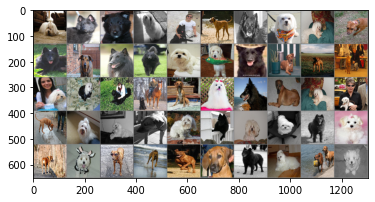

Test Data


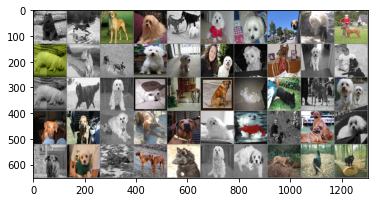

Validation Data


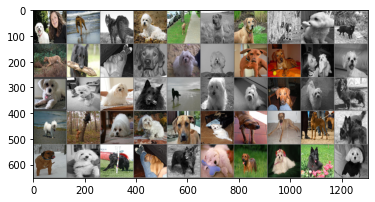

In [ ]:
num_img = 50 #megjelnítendő képek száma
nrow = 10    #egy sorba hány kép kerüljön

#Random képek megjelenítése

print("Train Data")
dataiter = iter(train3_gen)
images3, labels3 = dataiter.next()
print(len(images3))
imshow(torchvision.utils.make_grid(images3[0:num_img,:,:,:],  nrow = nrow))

print("Test Data")
dataiter = iter(test3_gen)
images3, labels3 = dataiter.next()
imshow(torchvision.utils.make_grid(images3[0:num_img,:,:,:],  nrow = nrow))

print("Validation Data")
dataiter = iter(val3_gen)
images3, labels3 = dataiter.next()
imshow(torchvision.utils.make_grid(images3[0:num_img,:,:,:],  nrow = nrow))


Tanítás

In [ ]:
if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(42)

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1  = nn.Conv2d(in_channels=3, out_channels=18, 
                                kernel_size=3, stride=1)   
        self.pool   = nn.MaxPool2d(kernel_size=2, stride=2)       
        self.conv2  = nn.Conv2d(n_channels=18, out_channels=32, 
                                kernel_size=3, stride=1)  
        self.bn1    = nn.BatchNorm2d(32)                          
        self.fc1    = nn.Linear(32*30*30, 128)                    
        self.bn2     = nn.BatchNorm1d(128)                         
        self.fc2    = nn.Linear(128, 64)                          
        self.fc3    = nn.Linear(64, num_classes)                  

    def forward(self, x):      
        # 3x128x128 -> 18x126x126 -> 18x63x63     
        x = self.pool(F.relu(self.conv1(x)))          
        # 18x63x63  -> 32x61x61   -> 32x30x30   
        x = self.pool(F.relu(self.bn1(self.conv2(x))))     
        # 32x30x30  -> 32*30*30
        x = x.view(-1,32*30*30)                          
        # 32*30*30  -> 128
        x = F.relu(self.bn2(self.fc1(x)))   
        # 128 -> 64             
        x = F.relu(self.fc2(x))                           
        # 64 -> num_classes
        x = self.fc3(x)                                   
        return x

In [ ]:
from torchvision import models
model = models.vgg16()
myModel = MyConvolutionalNetwork()
print(myModel)

MyConvolutionalNetwork(
  (conv1): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(18, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=28800, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(128 * 128 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):    
  # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [ ]:
def train(net, batch_size, n_epochs, learning_rate):
  
  ##Train a neural network and print statistics of the training

    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
     # (int) Number of iterations on the training set
    print("n_epochs=", n_epochs)           
    # (float) learning rate used by the optimizer
    print("learning_rate=", learning_rate)  
    print("=" * 30)
    
    train3_gen;
    n_minibatches = len(train3_gen)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)

    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    

    net = net.to(device)           # Move model to gpu if possible

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train3_gen):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
            print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
              epoch + 1, int(100.0 * torch.true_divide((i + 1), n_minibatches)), 
                                   torch.true_divide(running_loss, print_every),
                                   time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(torch.true_divide(total_train_loss, len(train3_gen)))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with torch.no_grad():
          for inputs, labels in val3_gen:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(torch.true_divide(total_val_loss, len(val3_gen)))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(torch.true_divide(
            total_val_loss, len(val3_gen))))

    print("Training Finished, took {:.2f}s".format(time.time() - 
                                                   training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history

In [ ]:
net = MyConvolutionalNetwork()

train_history, val_history = train(net, 
                                   batch_size=batch_size, 
                                   n_epochs=10, 
                                   learning_rate=0.001)

Eredmények

In [ ]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss",
             linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss",
             linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

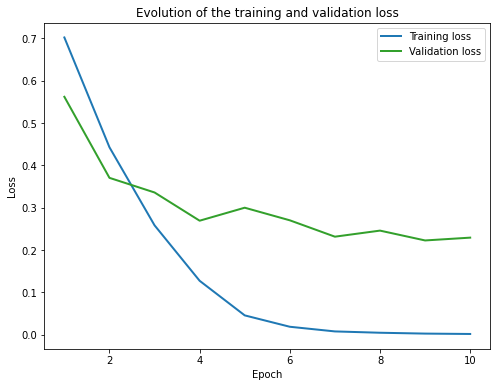

In [ ]:
plot_losses(train_history, val_history)  # evolution of the losses

In [ ]:
#Hibás képek kirajzolása

try:
  images, labels = next(iter(test3_gen))
except EOFError:
  pass

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
j = 1
for i in range(outputs.size()[0]):
  if(labels[i].numpy()!= predicted[i].cpu().numpy()):
    print("___________________________________________")
    print('{}. false detection' .format(j))
    print('Ground truth: {}  {}' .format(labels[i].numpy(), 
                                   classes3[labels[i].numpy()][10:] ))
    print('Predicted:    {}  {}' .format(predicted[i].cpu().numpy(), 
                                   classes3[predicted[i].cpu().numpy()][10:]))
    j = j+1
    imshow(images[i])
 
 

In [ ]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'
                      .format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train3_gen, "train")

def test_set_accuracy(net):
    dataset_accuracy(net, test3_gen, "test")

def val_set_accuracy(net):
    dataset_accuracy(net, val3_gen, "validation")  
    


def compute_accuracy(net):
    train_set_accuracy(net)
    test_set_accuracy(net)    
    val_set_accuracy(net)

    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 1380 train images: 100.00 %
Accuracy of the network on the 171 test images: 93.57 %
Accuracy of the network on the 171 validation images: 92.40 %


In [ ]:
def accuracy_per_class(net):
    net = net.to(device)
    
    # (real, predicted)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    for images, labels in test3_gen:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(images.size()[0]):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

#Az egyes osztályok pontosságának kiiratása és a confusion_matrix létrehozása
    print("{:<10} {:^10}".format("Accuracy", "Class\n"))
    for i in range(num_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:.2f} %      {:<10} '.format( percentage_correct, 
                                             classes3[i][10:]))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Accuracy     Class
  
100.00 %      Maltese_dog 
85.25 %      Rhodesian_ridgeback 
96.08 %      groenendael 


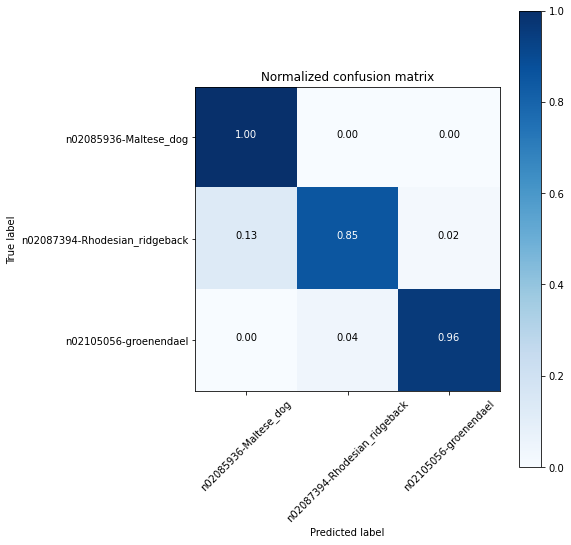

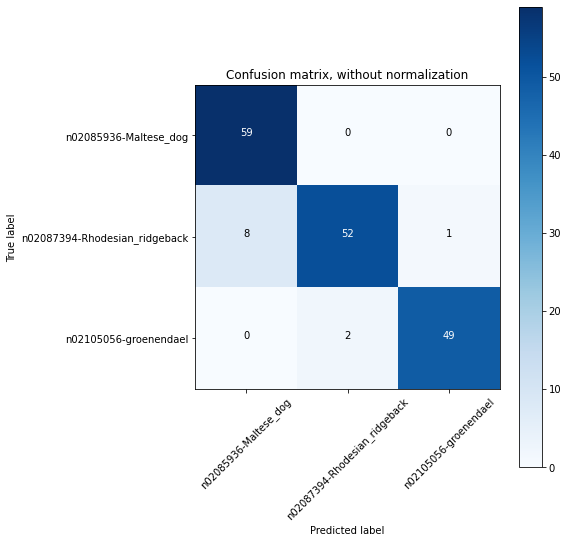

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes3, normalize=True, 
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes3, 
                      title='Confusion matrix, without normalization')